In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

In [2]:
community_embeddings = np.load('../../src/nlp/topic_modeling/community_embeddings.npy', allow_pickle=True)
user_embeddings = np.load('../../src/nlp/topic_modeling/user_embeddings.npy', allow_pickle=True)
users_role = pd.read_csv('../../src/data/distribuitions/hub_bridge_df.csv')

In [3]:
# Converting npy files into python dicts
users_role = users_role.loc[users_role['is_hub'] | users_role['is_bridge']]
user_emb_dict = {id_: emb for id_, emb in user_embeddings}
community_emb_dict = {id_: emb for id_, emb in community_embeddings}

# Adding embeddings to users dataframe
users_role['user_embedding'] = users_role['id'].map(user_emb_dict)
users_role['community_embedding'] = users_role['community_id'].map(community_emb_dict)

users_role.head()

,id,indegree,outdegree,degree,internal_degree,community_id,community_type,external_degree,pct_internal,pct_external,is_hub,is_bridge,user_embedding,community_embedding
43,ihatepasswords1234,12,18,30,4,42.0,Weak community,26,0.133333,0.866667,False,True,"[0.025258968714320595, 0.06435764916647153, -0...","[0.03552504424203346, 0.025611520230455702, 0...."
55,Beneficial-Diet-9897,5,3,8,1,9.0,Weak community,7,0.125000,0.875000,False,True,"[0.0530543441610147, -0.002833930553950461, -0...","[0.05405137977774946, 0.055702994649732766, -0..."
56,Beyond_Reason09,4,2,6,1,22.0,Weak community,5,0.166667,0.833333,False,True,"[0.034018017622919776, 0.0009661935282163791, ...","[0.008916618075831913, -0.005022937744415765, ..."
61,Hypekyuu,9,4,13,2,35.0,Weak community,11,0.153846,0.846154,False,True,"[0.02108485819425714, -0.02284914545776107, 0....","[0.00298966087739157, -0.008919504692544938, 3..."
66,ParticularBreath8425,7,3,10,2,68.0,Weak community,8,0.200000,0.800000,False,True,"[0.004725179139693849, 0.0517187069518997, 0.0...","[0.03018493073431906, 0.06962811543200365, -0...."


In [4]:
def compute_cosine_similarity(user_id):
    user = users_role[users_role['id'] == user_id]

    user_emb = np.array(user['user_embedding'].iloc[0]).reshape(1, -1)
    user_comm_emb = np.array(user['community_embedding'].iloc[0]).reshape(1, -1)

    similarity = cosine_similarity(user_emb, user_comm_emb)[0][0]

    return similarity

users_role['similarity'] = users_role['id'].apply(compute_cosine_similarity)
users_role.loc[users_role['is_hub']].head()

,id,indegree,outdegree,degree,internal_degree,community_id,community_type,external_degree,pct_internal,pct_external,is_hub,is_bridge,user_embedding,community_embedding,similarity
115,AlexandrTheTolerable,6,48,54,50,0.0,Strong community,4,0.925926,0.074074,True,False,"[0.07080968057837261, -0.02623702846708768, 0....","[0.020105618885145216, -0.02229900076280347, 0...",0.780010
118,Ashmedai,27,31,58,57,0.0,Strong community,1,0.982759,0.017241,True,False,"[-0.01722518107329667, -0.007501278659543933, ...","[0.020105618885145216, -0.02229900076280347, 0...",0.905306
129,Interrophish,26,37,63,61,0.0,Strong community,2,0.968254,0.031746,True,False,"[-0.007306234168659299, -0.02148232899896843, ...","[0.020105618885145216, -0.02229900076280347, 0...",0.958625
134,ManBearScientist,23,21,44,43,0.0,Strong community,1,0.977273,0.022727,True,False,"[0.01546294113595632, -0.03374321900382998, 0....","[0.020105618885145216, -0.02229900076280347, 0...",0.914008
135,Moccus,34,37,71,66,0.0,Strong community,5,0.929577,0.070423,True,False,"[-0.002364396811896156, -0.03920532943097499, ...","[0.020105618885145216, -0.02229900076280347, 0...",0.867521


In [5]:
users_role.to_csv('users_similarity.csv', sep=',', encoding='utf-8', index=False)

In [6]:
users_role.loc[users_role['is_hub']]['similarity'].agg(('count', 'mean', 'median', 'std'), axis=0)

count     80.000000
mean       0.891694
median     0.911240
std        0.066544
Name: similarity, dtype: float64

In [7]:
hub_sim_list = users_role.loc[users_role['is_hub']]['similarity']
hub_sim = pd.Series(hub_sim_list)

In [8]:
users_role.loc[users_role['is_bridge']]['similarity'].agg(('count', 'mean', 'median', 'std'), axis=0)

count     204.000000
mean        0.795442
median      0.809163
std         0.102813
Name: similarity, dtype: float64

In [9]:
bridge_sim_list = users_role.loc[users_role['is_bridge']]['similarity']
bridge_sim = pd.Series(bridge_sim_list)

In [10]:
# Assumendo che hub_sim e bridge_sim siano Series con le similarità
# 1. Test di normalità
print("Shapiro Hub:", shapiro(hub_sim))
print("Shapiro Bridge:", shapiro(bridge_sim))

# 2. Test di omogeneità delle varianze
print("Levene:", levene(hub_sim, bridge_sim))

# 3. Scegli il test in base ai risultati
if shapiro(hub_sim).pvalue > 0.05 and shapiro(bridge_sim).pvalue > 0.05:
    # Normali
    if levene(hub_sim, bridge_sim).pvalue > 0.05:
        # Varianze uguali
        print("T-test:", ttest_ind(hub_sim, bridge_sim))
    else:
        # Varianze diverse
        print("T-test var unequal:", ttest_ind(hub_sim, bridge_sim, equal_var=False))
else:
    # Non normali → Mann-Whitney
    print("Mann-Whitney:", mannwhitneyu(hub_sim, bridge_sim, alternative='two-sided'))


Shapiro Hub: ShapiroResult(statistic=np.float64(0.754852830366356), pvalue=np.float64(3.096968164384261e-10))
Shapiro Bridge: ShapiroResult(statistic=np.float64(0.9630896175301131), pvalue=np.float64(3.612628793797862e-05))
Levene: LeveneResult(statistic=np.float64(24.580652025743465), pvalue=np.float64(1.2321469917291606e-06))
Mann-Whitney: MannwhitneyuResult(statistic=np.float64(13263.0), pvalue=np.float64(2.4894064080183746e-16))


/tmp/ipykernel_17620/4173588978.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([hub_data, bridge_data], labels=["Hub", "Bridge"])


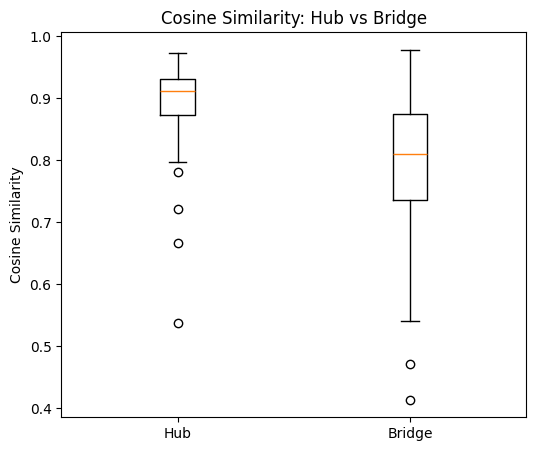

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Dati simulati dai risultati forniti
hub_data = pd.Series(name="Hub", data=hub_sim)  # Solo come placeholder
bridge_data = pd.Series(name="Bridge", data=bridge_sim)  # Placeholder

# In realtà dovresti usare i tuoi dati reali di similarità
# Qui userò i valori reali se me li fornisci, altrimenti rappresento con placeholder

# Creazione del boxplot
fig, ax = plt.subplots(figsize=(6, 5))
ax.boxplot([hub_data, bridge_data], labels=["Hub", "Bridge"])
ax.set_title("Cosine Similarity: Hub vs Bridge")
ax.set_ylabel("Cosine Similarity")
plt.show()
